In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler,Normalizer,RobustScaler
from sklearn.pipeline import make_pipeline


from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

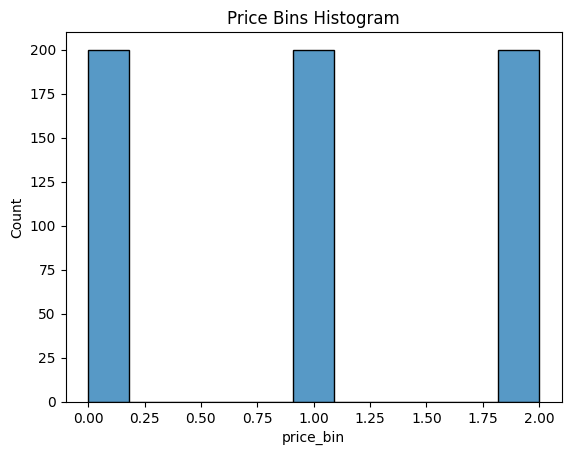

In [37]:
df = pd.read_csv('processed.csv', index_col=0)

df.drop(labels=['Price'], axis=1, inplace=True)

df = df.sample(frac=1, random_state=1)

over_sampling_strategy = {  
    1: 200,  
    2: 200   
}
under_sampling_strategy = { 
    0: 200
}

ros = RandomOverSampler(random_state=0,sampling_strategy=over_sampling_strategy)
rus = RandomUnderSampler(random_state=0,sampling_strategy=under_sampling_strategy)

pipeline = Pipeline([
    ('over',ros),
    ('under',rus)
])

X = df.drop(labels=['price_bin'], axis=1, inplace=False)
y = df['price_bin']

X_resampled, y_resampled = pipeline.fit_resample(X, y)

plt.title('Price Bins Histogram')
sns.histplot(y_resampled)
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [47]:
from sklearn.feature_selection import f_classif

f, p = f_classif(X_train, y_train)


for i in range(len(f)):

    print(f"Column {i}: f-statistic {f[i]} & p value: {p[i]}")


Column 0: f-statistic 2.7922294821850877 & p value: 0.06228647413676292
Column 1: f-statistic 38.57872076584211 & p value: 2.952041523589596e-16
Column 2: f-statistic 57.109181552281974 & p value: 5.817759305562535e-23
Column 3: f-statistic 134.7070878871761 & p value: 4.1776523017014945e-47
Column 4: f-statistic 158.90960105000806 & p value: 1.2960798373815354e-53
Column 5: f-statistic 26.869979614046787 & p value: 8.7564336883205e-12
Column 6: f-statistic 72.7276403442434 & p value: 2.702951597817211e-28
Column 7: f-statistic 29.25011523374186 & p value: 1.041007828103885e-12
Column 8: f-statistic 20.162810426664894 & p value: 3.9257473974659186e-09
Column 9: f-statistic 12.299893327951594 & p value: 6.185959473198008e-06
Column 10: f-statistic 4.133508273067729 & p value: 0.0166042373444675
Column 11: f-statistic 7.189168686887386 & p value: 0.0008392973450666262
Column 12: f-statistic 15.345544559126095 & p value: 3.476505437004404e-07
Column 13: f-statistic 117.579851779657 & p va

In [ ]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X_train, y_train)

for i in range(len(mi)):

    print(f"Column {i} mutual information: {mi[i]}")

[0.35250768 0.18374738 0.24092479 0.25645831 0.40820296 0.09173972
 0.2568939  0.36012165 0.13280089 0.02277006 0.01318726 0.04625035
 0.02315682 0.24338445]


In [31]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


### -------- attempt at feature selection --------------------- ###

selector = SelectKBest(f_classif, k=14) # k is the number of features to be selected, 14 or 16 
X_new = selector.fit_transform(X, y)

X_resampled, y_resampled = pipeline.fit_resample(X_new, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [34]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

rfe = RFE(model, n_features_to_select=6)

scaler = StandardScaler().fit(X)
scaled_X = scaler.transform(X)

selector = rfe.fit(scaled_X, y)

In [35]:
x__new = selector.fit_transform(scaled_X, y)
X_train, X_test, y_train, y_test = train_test_split(x__new, y, test_size=0.2, random_state=42)

In [39]:
# Decision Tree
from sklearn.ensemble import RandomForestClassifier
pipeline_two = Pipeline([
     ('classifier', RandomForestClassifier())
])
param_grid = {
    'classifier__n_estimators': [4, 8, 16, 20],
    'classifier__max_depth': [None, 4, 8, 16],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [2, 4, 6]
}

def make_model(model,param_grid,scoring,X_train,Y_train):
    np.random.seed(0)
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scoring)
    grid_search.fit(X_train, Y_train)
    
    print("Best Parameter:", grid_search.best_params_)
    print(f"Best {scoring}:", grid_search.best_score_)
    
    return grid_search.best_estimator_

def evaluate_classifier(model,X_train,Y_train,X_test,Y_test):
    
    train_prediction = model.predict(X_train)
    
    train_accuracy = accuracy_score(Y_train, train_prediction)
    train_f1 = f1_score(Y_train, model.predict(X_train),average='weighted')
    
    print("Train Classification Results")
    print(classification_report(Y_train,train_prediction))
    
    print("------------------------------")
    test_prediction = model.predict(X_test)
    test_accuracy = accuracy_score(Y_test, test_prediction)
    test_f1 = f1_score(Y_test, model.predict(X_test),average='weighted')
    
    print("Test Classification Results")
    print(classification_report(Y_test,test_prediction))


    
    return train_accuracy,train_f1,test_accuracy,test_f1


model_decision_tree = make_model(pipeline_two,param_grid,'accuracy',X_train,y_train)

evaluate_classifier(model_decision_tree,X_train,y_train,X_test,y_test)

Best Parameter: {'classifier__max_depth': 16, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 16}
Best accuracy: 0.7958333333333333
Train Classification Results
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       157
           1       0.93      0.96      0.95       164
           2       1.00      0.99      0.99       159

    accuracy                           0.96       480
   macro avg       0.96      0.96      0.96       480
weighted avg       0.96      0.96      0.96       480

------------------------------
Test Classification Results
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        43
           1       0.83      0.83      0.83        36
           2       0.98      0.98      0.98        41

    accuracy                           0.90       120
   macro avg       0.90      0.90      0.90       120
weighted avg       0.9

c:\Users\user\.conda\envs\cs573\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


(0.9625, 0.9626085869298561, 0.9, 0.9)

In [60]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True)

for train_index, test_index in kf.split(X_train):
    xgb_model = xgb.XGBClassifier(objective = 'multi:softmax').fit(X_train.iloc[train_index], y_train.iloc[train_index])

    predictions = xgb_model.predict(X_train.iloc[test_index])
    actuals = y_train.iloc[test_index]

    print(confusion_matrix(actuals, predictions))
    print(f"f1: {f1_score(predictions, actuals, average='macro')}")
    print(f"precision_score: {precision_score(predictions, actuals, average='macro')}")
    print(f"recall_score: {recall_score(predictions, actuals, average='macro')}")
    print(f"accuracy: {accuracy_score(predictions, actuals)}")

[[23  3  2]
 [ 2 28  2]
 [ 1  4 31]]
f1: 0.8536373946646526
precision_score: 0.8525132275132276
recall_score: 0.8567765567765567
accuracy: 0.8541666666666666
[[23  8  1]
 [ 3 24  4]
 [ 0  5 28]]
f1: 0.7824902165672958
precision_score: 0.7804761322906484
recall_score: 0.7939162939162939
accuracy: 0.78125
[[29  8  0]
 [ 7 16  2]
 [ 3  1 30]]
f1: 0.7707496012759171
precision_score: 0.7687122416534181
recall_score: 0.7736965811965812
accuracy: 0.78125
[[26  9  0]
 [ 3 27  4]
 [ 0  0 27]]
f1: 0.8383210180623973
precision_score: 0.8456582633053221
recall_score: 0.839173155357805
accuracy: 0.8333333333333334
[[24  0  1]
 [ 4 30  8]
 [ 2  2 25]]
f1: 0.8257296257296257
precision_score: 0.8454515599343185
recall_score: 0.8242647058823529
accuracy: 0.8229166666666666


In [ ]:
# KNN
pipeline_two = Pipeline([
     ('classifier', RandomForestClassifier())
])
param_grid = {
    'classifier__n_estimators': [4, 8, 16],
    'classifier__max_depth': [None, 4, 8, 16],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

modelknn = make_model(pipeline_two,param_grid,'accuracy',X_train,y_train)


pipeline_two = Pipeline([
     ('standardscaler', StandardScaler()),
     ('classifier', RandomForestClassifier())
])

modelknn_std_scaler = make_model(pipeline,param_grid,'accuracy',X_train,y_train)

pipeline = make_pipeline(Normalizer(), RandomForestClassifier())

modelknn_std_scaler = make_model(pipeline,param_grid,'accuracy',X_train,y_train)

pipeline = make_pipeline(RobustScaler(), RandomForestClassifier())

modelknn_std_scaler = make_model(pipeline,param_grid,'accuracy',X_train,y_train)

Best Parameter: {'classifier__max_depth': 16, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 16}
Best accuracy: 0.825


ValueError: Invalid parameter 'classifier' for estimator Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())]). Valid parameters are: ['memory', 'steps', 'verbose'].

In [21]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
pipeline_two = Pipeline([
     ('classifier', DecisionTreeClassifier())
])
param_grid = {
    'classifier__max_depth': [None, 5, 10, 15],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

def make_model(model,param_grid,scoring,X_train,Y_train):
    np.random.seed(0)
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scoring)
    grid_search.fit(X_train, Y_train)
    
    print("Best Parameter:", grid_search.best_params_)
    print(f"Best {scoring}:", grid_search.best_score_)
    
    return grid_search.best_estimator_

def evaluate_classifier(model,X_train,Y_train,X_test,Y_test):
    
    train_prediction = model.predict(X_train)
    
    train_accuracy = accuracy_score(Y_train, train_prediction)
    train_f1 = f1_score(Y_train, model.predict(X_train),average='weighted')
    
    print("Train Classification Results")
    print(classification_report(Y_train,train_prediction))
    
    print("------------------------------")
    test_prediction = model.predict(X_test)
    test_accuracy = accuracy_score(Y_test, test_prediction)
    test_f1 = f1_score(Y_test, model.predict(X_test),average='weighted')
    
    print("Test Classification Results")
    print(classification_report(Y_test,test_prediction))


    
    return train_accuracy,train_f1,test_accuracy,test_f1

model_decision_tree = make_model(pipeline_two,param_grid,'accuracy',X_train,y_train)

Best Parameter: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best accuracy: 0.7958333333333333
